In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dropout, Dense, RepeatVector, TimeDistributed, Flatten


seq_size = 32
skip_samples = 10000

2023-06-05 23:25:11.942912: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 23:25:12.231514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 23:25:12.233031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 23:25:14.603510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# dataset = np.array([])
# for file in sorted(glob.glob('data/CIR_Masaryk3_040423_big_1.csv')):
# 	print(file)
# 	data = np.loadtxt(file, delimiter=',')
# 	complex_data = np.vectorize(complex)(data[skip_samples:, 0], data[skip_samples:, 1])
# 	dataset = np.append(dataset,complex_data)
# print(dataset.head())
# data = 20 * np.log10(abs(dataset))

data/CIR_Masaryk3_040423_big_1.csv


KeyboardInterrupt: 

In [2]:
data = np.loadtxt('data/CIR_Masaryk3_040423_big_1.csv', delimiter=',')

In [3]:
data.shape

(23521, 32768)

In [3]:
dataset = []
for i in range(0,200, 2):
	#dont use first 10k and last 4k data
	#SLICE data
	data_short = data[10000:-4000,i:i+2]
	complex_data = np.vectorize(complex)(data_short[:, 0], data_short[:, 1])
	log_data = 20 * np.log10(abs(complex_data))
	dataset.append(log_data.reshape(-1,1))

In [4]:
len(dataset)

250

In [8]:
# Je tam 23521 radku, a to je cele mereni. Patri k tomu vzdy dva sloupce. Prvni je I druhy je Q., tzn 32k\2=16k

In [5]:
for file in dataset:
	scaler = MinMaxScaler()
	scaler = scaler.fit(file)

for i,data in enumerate(dataset):
	dataset[i] = scaler.transform(data)

train = dataset[:249]
test = dataset[-1:]

In [7]:
len(train)

999

In [6]:
x_values = []
y_values = []

testx_values = []
testy_values = []

def to_sequences(x_values, y_values, x, y, seq_size):
    for i in range(len(x) - seq_size):
        x_values.append(x[i:i+seq_size])
        y_values.append(y[i+seq_size])


for file in train:
	to_sequences(x_values, y_values, file, file, seq_size)

for file in test:
	to_sequences(testx_values, testy_values, file, file, seq_size)

trainX = np.array(x_values)
trainY = np.array(y_values)

testX = np.array(testx_values)
testY = np.array(testy_values)

In [26]:
testX.shape

(9505, 16, 1)

In [7]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(RepeatVector(128))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(rate=0.2))

model.add(TimeDistributed(Dense(trainX.shape[2])))

model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(trainX, trainY, epochs=5, batch_size=256, validation_split=0.1, verbose=1)

2023-06-05 23:30:30.056296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-05 23:30:30.058677: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/5


2023-06-05 23:30:31.382755: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 272189952 exceeds 10% of free system memory.


   94/16614 [..............................] - ETA: 1:18:21 - loss: 0.0376

KeyboardInterrupt: 

In [190]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 16, 128)           66560     
                                                                 
 dropout_8 (Dropout)         (None, 16, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 32, 64)           0         
 or)                                                             
                                                      

In [77]:
testPredict = model.predict(testX)

298/298 [==============================] - 5s 16ms/step


In [78]:
testPredict[1000]

array([[0.3659857 ],
       [0.36439937],
       [0.36286542],
       [0.36058673],
       [0.35836956],
       [0.35650575],
       [0.35501572],
       [0.35385796],
       [0.35297695],
       [0.35231632],
       [0.35182407],
       [0.3514557 ],
       [0.35117555],
       [0.35095698],
       [0.35078132],
       [0.3506363 ],
       [0.35051417],
       [0.35041034],
       [0.35032195],
       [0.35024714],
       [0.35018444],
       [0.35013255],
       [0.35009015],
       [0.35005602],
       [0.35002887],
       [0.35000756],
       [0.34999102],
       [0.3499784 ],
       [0.34996876],
       [0.34996158],
       [0.34995627],
       [0.3499524 ]], dtype=float32)

In [158]:
mean_pred=np.mean(testPredict,axis=1)

In [91]:
test[0][16:]


array([[0.32025863],
       [0.30091831],
       [0.31437692],
       ...,
       [0.39624019],
       [0.43231313],
       [0.45789185]])

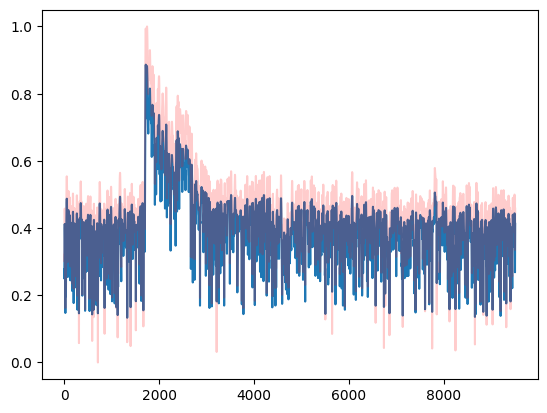

In [159]:
plt.plot(mean_pred)
plt.plot(test[0][16:], color='r',alpha =0.2)
plt.show()

In [160]:
testMAE = np.mean(np.abs(mean_pred - test[0][16:]), axis=1)
print(testMAE)

[0.0424927  0.05106214 0.03436544 ... 0.0351264  0.04526611 0.04520061]


In [183]:
q = np.quantile(testMAE, 0.95)

In [184]:
q_filter = np.where(testMAE > q)

In [185]:
print(q_filter)

(array([ 709, 1398, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710,
       1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721,
       1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732,
       1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743,
       1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754,
       1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765,
       1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776,
       1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787,
       1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798,
       1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809,
       1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820,
       1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831,
       1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842,
       1843, 1844, 1845, 1846, 1847, 1848, 1849, 1

In [186]:
max_filter = np.argpartition(testMAE, -10)[-10:]

In [187]:
max_filter.reshape(1,-1)

array([[1797, 1798, 1736, 1735, 1733, 1732, 1731,  709, 3212, 1734]])

In [188]:
maxima = []
maxima2 = []
for i in range(0,len(testMAE),2000):

	a = testMAE[i:i+2000]
	top = np.argpartition(a,-1)[-1]
	if testMAE[top+i] > q:
		maxima.append(top+i)
print(maxima)

for i in range(0,len(testMAE),500):
	a = testMAE[i:i+500]
	top = np.argpartition(a,-1)[-1]
	if testMAE[top+i] > q:
		maxima2.append(top+i)
print(maxima2)



[709, 3212, 5645, 6738, 8245]
[709, 1398, 1732, 2347, 2571, 3212, 4199, 5645, 6738, 7754, 8245]


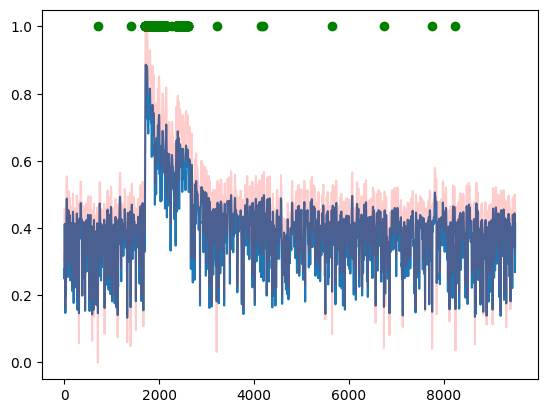

In [189]:
# plt.scatter([1592, 3810, 5222], [-20,-20, -20], color='r')
plt.scatter(q_filter[0], np.full(len(q_filter[0]), 1), color='g')
plt.plot(mean_pred)
plt.plot(test[0][16:], color='r',alpha =0.2)
plt.show()



In [168]:
q_filter[0]


array([ 709, 1705, 1706, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733,
       1734, 1735, 1736, 1737, 1738, 1739, 1744, 1745, 1746, 1747, 1748,
       1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759,
       1760, 1761, 1762, 1763, 1764, 1770, 1771, 1772, 1773, 1774, 1775,
       1776, 1784, 1785, 1786, 1787, 1788, 1789, 1794, 1795, 1796, 1797,
       1798, 1799, 1800, 1801, 1802, 1803, 1812, 1813, 1814, 1815, 1816,
       1817, 1818, 1819, 1820, 1821, 1822, 1829, 1830, 1831, 1832, 1844,
       1845, 1846, 1847, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879,
       1964, 1986, 1987, 2347, 3212, 5645, 6738, 8245])